In [16]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import beta

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, get_scorer_names, r2_score
from sklearn.tree import plot_tree
from sklearn import preprocessing

In [2]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [3]:
# read in models
xgb = read_pickle('models/', 'xgb_prequal_racepos')
b_fits = pd.read_csv('models/beta_fits.csv')

In [4]:
# read in data
f1 = pd.read_csv('data/f1_master_cleaned.csv')
f1.drop(3490, inplace=True)
f1.reset_index(drop=True, inplace=True)

In [5]:
# first, identify correlation between race place and points
f1_sub = f1[['position_num','fantasy_points']].dropna()

X = f1_sub[f1_sub['position_num'] <= 10]['position_num']
y = f1_sub[f1_sub['position_num'] <= 10]['fantasy_points']
X = np.array(X).reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("R-squared:", r2_score(y, y_pred))
top10_intercept = model.intercept_
top10_slope = model.coef_[0]
print('Fantasy points = ' + str(round(top10_intercept, 2)) + ' + ' + str(round(top10_slope, 2)) + '*race_position')

R-squared: 0.6901349566730006
Fantasy points = 39.39 + -3.58*race_position


For cars finishing in the top 10, there is a good relationship between race place and and fantasy points.

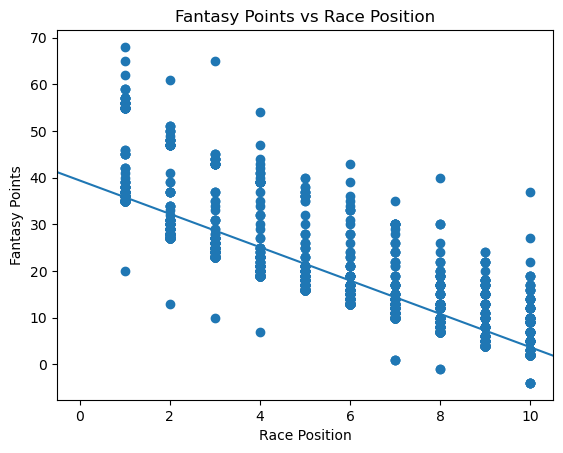

In [6]:
plt.scatter(X, y)
plt.title('Fantasy Points vs Race Position')
plt.xlabel('Race Position')
plt.ylabel('Fantasy Points')
plt.axline((0, top10_intercept), slope=top10_slope)
plt.show()

In [7]:
f1_sub = f1[['position_num','fantasy_points']].dropna()
# now take drivers finishing in the bottom half
X = f1_sub[f1_sub['position_num'] > 10]['position_num']
y = f1_sub[f1_sub['position_num'] > 10]['fantasy_points']
X = np.array(X).reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("R-squared:", r2_score(y, y_pred))

R-squared: 0.1174794535285002


For cars finishing outside the top 10, there is almost no correlation between points and finishing place.

In [8]:
f1_sub = f1[['gridPosition','fantasy_points']].dropna()

X = f1_sub[f1_sub['gridPosition'] > 10]['gridPosition']
y = f1_sub[f1_sub['gridPosition'] > 10]['fantasy_points']
X = np.array(X).reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("R-squared (grid):", r2_score(y, y_pred))
print('Intercept: ', model.intercept_)

R-squared (grid): 0.0004728951449537444
Intercept:  0.637033967595203


Additionally, there is no correlation between grid position and fantasy points for drivers starting outside the top 10 on the grid.

In [9]:
IQR = y.quantile(0.75) - y.quantile(0.25)
upper_bnd = y.mean() + 1.5*IQR
lower_bnd = y.mean() - 1.5*IQR

y = y[(y > lower_bnd) & (y < upper_bnd)]
bottom10_mean = 5
bottom10_std = 6
y.describe()


count    1617.000000
mean        5.263451
std         6.116332
min       -15.000000
25%         0.000000
50%         5.000000
75%         9.000000
max        19.000000
Name: fantasy_points, dtype: float64

Now, for an individual driver is there a correlation with starting grid position and fantasy points? Both for a "good" driver and for drivers typically near the back.

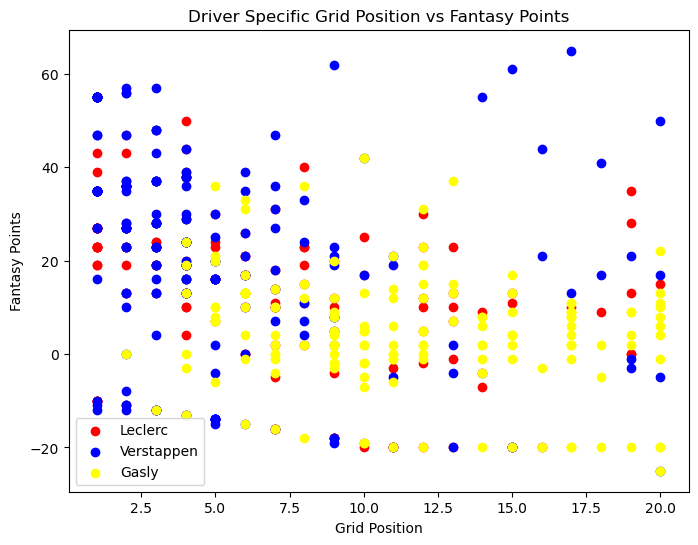

In [48]:
lec_df = f1[f1['driverId'] == 'leclerc']
ver_df = f1[f1['driverId'] == 'verstappen']
zho_df = f1[f1['driverId'] == 'zhou']
gas_df = f1[f1['driverId'] == 'gasly']

plt.figure(figsize=(8,6))
plt.scatter(x=lec_df['gridPosition'], y=lec_df['fantasy_points'], c='red', label='Leclerc')
plt.scatter(x=ver_df['gridPosition'], y=ver_df['fantasy_points'], c='blue', label='Verstappen')
#plt.scatter(x=zho_df['gridPosition'], y=zho_df['fantasy_points'], c='yellow', label='Zhou')
plt.scatter(x=gas_df['gridPosition'], y=gas_df['fantasy_points'], c='yellow', label='Gasly')
plt.title('Driver Specific Grid Position vs Fantasy Points')
plt.xlabel('Grid Position')
plt.ylabel('Fantasy Points')
plt.legend()
plt.show()

For the top drivers capable of getting lots of overtakes done and moving up many places, there seems to be an advantage to starting further back in the starting grid rather than being near the middle. There is bigger upside with the potential for big scores, with no additional risk taken from starting near the back.

For below average drivers, there doesn't appear to be much correlation with starting position and fantasy points.

# Create Monte-Carlo Race Simulation

Steps taken to create a Monte-Carlo race-sim.
1. Get an expected race place for each driver based on the XGBoost regression model.
2. For each driver, identify which two beta fit models to use (whole number above and below the expected place).
3. Randomly select which of the two beta fit models to use, weighted accordingly.
4. Using the selected beta PDF, randomly generate a randomized race place for each driver.
5. Rank the drivers according to their random race place.
6. Get the predicted fantasy points for each driver based on this race order.
7. Repeat the above steps N times.

In [10]:
def race_monte_carlo(race, n_sim=300):
    # simulates the 'race' n_sim number of times
    # returns n_sim number of fantasy points for each driver
    
    race_new = race.copy()
    
    # get XBoost prediction
    race_new['exp_place'] = xgb.best_estimator_.predict(race)
    #print(race_new['exp_place'])
    
    race_results = pd.DataFrame(index=range(n_sim),columns=range(1, len(race)+1))
    
    for i_race in range(0, n_sim):
        race_new['beta_place'] = 0
    
        for i in range(0, len(race_new)): # loop through every driver

            # Select the two beta fit models to use
            #lo_place = math.floor(race_new.loc[i, 'exp_place'])
            #hi_place = lo_place + 1
            #betas = b_fits.iloc[lo_place: hi_place + 1]
        
            # Get the weighting parameter to choose between the two betas
            # beta_weight has value [0, 1]. Represents the probability of using the higher beta fit 
            #beta_weight = race_new.loc[i, 'exp_place'] - lo_place
            
            #use_hi = int(np.random.uniform(0, 1) < beta_weight)
            #a = b_fits.loc[use_hi, 'a']
            #b = b_fits.loc[use_hi, 'b']
            #scale = b_fits.loc[use_hi, 'scale']
            
            # use beta pdf to generate random place
            #race_new.loc[i, 'beta_place'] = beta.rvs(a, b, 1, scale)
            exp_place = race_new.loc[i, 'exp_place']
            exp_std = 2*(20 - exp_place)/20 + 3*exp_place/20
            race_new.loc[i, 'beta_place'] = np.random.normal(loc=exp_place, scale=exp_std)
            #print(race_new.loc[i, 'beta_place'])
        
        ### END loop through each driver
        
        # sort the race by beta place
        race_order = race_new.sort_values('beta_place').reset_index(drop=True)
        
        # store the results in race_results
        all_columns = race_order.columns
        driverIds = [s for s in all_columns if 'driverId' in s]
        
        for i in range(0, len(race_order)):
            for driverId in driverIds:
                if (race_order.loc[i, driverId] == 1):
                    race_results.iloc[i_race, i] = driverId.split('_')[-1]
                    break
                    
            ### END loop through each driverId
        ### END loop through the race_order
        
    ### END loop through all n_sim races
    return race_results


In [11]:
xgb_predictors = ['driverId','constructorId','round','circuitId',
                 'fp1_position','fp2_position','fp3_position','fp1_gap','fp2_gap','fp3_gap','risky_circuit',
                 'position_minus1','fantasy_points_minus1',
                 'position_minus2','fantasy_points_minus2']

X_race = f1[xgb_predictors]
drivers = f1['driverId'].unique()
X_race_dummies = pd.get_dummies(X_race,columns=['driverId','constructorId','circuitId'])

race1 = X_race_dummies.tail(19).reset_index(drop=True)

race_pred = race_monte_carlo(race1, 500)

In [20]:
def monte_carlo_results(f1_df, mc_df, plot_heatmap=False):
    # process the results of a monte carlo dataframe
    res = pd.DataFrame(index=f1_df['driverId'],columns=range(1, len(f1_df)+1))
    
    for column in res.columns:
        counts = mc_df[column].value_counts(normalize=True)
        for driver, count in counts.items():
            percent = round(count, 3)*100
            if(percent < 0.25):
                res.loc[driver, column] = 0
            else:
                res.loc[driver, column] = round(count, 3)
    
    # convert NaN to 0
    res.fillna(0, inplace=True)
    # sort by likliest outcome
    res.sort_values(by=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], ascending=[False]*15, inplace=True)
    
    # normalize each column
    res = res/res.sum()*100
    
    if(plot_heatmap): 
        plt.figure(figsize=(9, 6.6))
        sns.heatmap(res, annot=True, cmap='Blues', linewidths=0.5, cbar=False, vmax=35)
        plt.title(f1_df['circuitId'].iloc[0] + ' ' + str(f1_df['year'].iloc[0]) + ' - Race Predictions')
        plt.show()
    
    return res

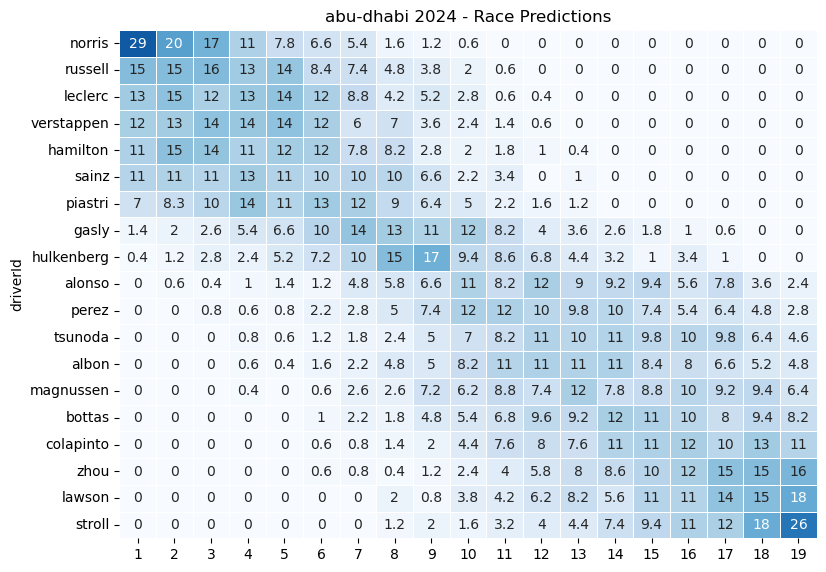

In [21]:
f1_sub = f1.tail(19)
res = monte_carlo_results(f1_sub, race_pred, True)

In [22]:
def predicted_winner(res_df):
    # from a monte-carlo dataframe, select the driver most likely to win
    return res_df.index[0]

def actual_winner(race_df):
    # from the master f1 dataframe, return the winner of the race
    return race_df['driverId'].iloc[0]

In [23]:
def season_monte_carlo(f1, year, n_sim=500):
    # compare the predicted and actual race winners for each race of a season
    
    # first get the prediction dataframe
    xgb_predictors = ['driverId','constructorId','round','circuitId',
                 'fp1_position','fp2_position','fp3_position','fp1_gap','fp2_gap','fp3_gap','risky_circuit']

    X = f1[xgb_predictors]
    X = pd.get_dummies(X,columns=['driverId','constructorId','circuitId'])
    
    f1_yr = f1[f1['year'] == year]
    X_yr = X[f1['year'] == year]
    circuits = f1_yr['circuitId'].unique()

    race_pred = race_monte_carlo(race1, n_sim)
    
    race_count = 0
    
    for circuit in circuits:
        race_count += 1
        print(circuit + ' (' + str(race_count) + '/' + str(len(circuits)) + ')')
        # get all drivers for that circuit
        f1_race = f1_yr[f1_yr['circuitId'] == circuit].reset_index(drop=True)
        X_race = X_yr[f1_yr['circuitId'] == circuit].reset_index(drop=True)
        
        # run the monte carlo
        race_mc = race_monte_carlo(X_race, n_sim)
        
        # summarize monte carlo results
        race_res = monte_carlo_results(f1_race, race_mc)
        
        # compare predicted with actual winner
        #print('    Predicted winner: ' + predicted_winner(race_res))
        #print('    Actual winner:    ' + actual_winner(f1_race))
        
    ### END loop through circuit

In [24]:
def predicted_driver_points(res_df):
    # for each driver, return the predicted fantasy points from the monte carlo data
    race_pts = pd.DataFrame(index=res_df.index, columns=['predicted_points',
                                                         'Q3_probability','Q2_probability', 'Q1_probability'])
    
    bottom10_mean_points = 2
    race_pts['Q1_probability'] = 0
    race_pts['Q2_probability'] = 0
    race_pts['Q3_probability'] = 0
    
    for driver in res_df.index:
        race_pts.loc[driver, 'predicted_points'] = 0
        for place in res_df.columns:
            
            probability = res_df.loc[driver, place]/100
            
            # use different predictions for top 10 and bottom 10
            if(place <= 10):
                # top 10 use linear fit
                race_pts.loc[driver, 'predicted_points'] += (top10_intercept + top10_slope*place)*probability
                race_pts.loc[driver, 'Q3_probability'] += probability
            else:
                # two points average for bottom 10
                race_pts.loc[driver, 'predicted_points'] += bottom10_mean_points*probability
                if(place <= 15):
                    race_pts.loc[driver, 'Q2_probability'] += probability
                else:
                    race_pts.loc[driver, 'Q1_probability'] += probability
                
            
        ### END loop through each place
    ### END loop through each driver
    
    race_pts.sort_values('predicted_points', inplace=True, ascending=False)
    
    return race_pts

In [25]:
def add_actual_points_to_fantasy(f1, race_pts):
    # for each driver in the race, add their actual fantasy points to their prediction
    race_pts['actual_points'] = 0
    for driver in race_pts.index:
        act_points = f1[f1['driverId'] == driver]['fantasy_points']
        race_pts.loc[driver, 'actual_points'] = act_points.values[0]
    ### END loop through drivers
    
    return race_pts

In [26]:
def get_all_predicted_points(f1_df):
    # loop through all the races and get the predicted points
    
    f1_out = f1_df.copy()
    f1_out['predicted_points'] = 0
    f1_out['predicted_winner'] = 0
    
    xgb_predictors = ['driverId','constructorId','round','circuitId',
                 'fp1_position','fp2_position','fp3_position','fp1_gap','fp2_gap','fp3_gap','risky_circuit',
                 'position_minus1','fantasy_points_minus1',
                 'position_minus2','fantasy_points_minus2']
    
    X = f1_df[xgb_predictors]
    X = pd.get_dummies(X,columns=['driverId','constructorId','circuitId'])
    
    years = f1_df['year'].unique()
    
    for year in years:
        print(year)
        # get all races this year
        f1_yr = f1_df[f1_df['year'] == year]
        X_yr = X[f1_df['year'] == year]
        
        # find all the rounds this year
        circuits = f1_yr['circuitId'].unique()
        
        for circuit in circuits:
            # get all drivers for this round
            f1_race = f1_yr[f1_yr['circuitId'] == circuit].reset_index(drop=True)
            X_race = X_yr[f1_yr['circuitId'] == circuit].reset_index(drop=True)
            
            # run monte-carlo
            race_pred = race_monte_carlo(X_race, 500)
            
            # aggregate monte-carlo results
            res = monte_carlo_results(f1_race, race_pred, False)
            
            # convert monte-carlo results into predicted fantasy points
            pts_df = predicted_driver_points(res)
            
            # add fantasy points back to original df
            for driver in pts_df.index:
                mask = (f1_out['driverId'] == driver) & (f1_out['year'] == year) & (f1_out['circuitId'] == circuit)
                f1_out.loc[mask, 'predicted_points'] = pts_df.loc[driver, 'predicted_points']
                if(driver == pts_df.index[0]):
                    f1_out.loc[mask, 'predicted_winner'] = 1
                
            ### END loop through all drivers
            
        ### END loop through all rounds
        
    ### END loop through all years
    
    return f1_out
            

In [27]:
f1_pts = get_all_predicted_points(f1)

2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


R-squared: 0.5070129275058489


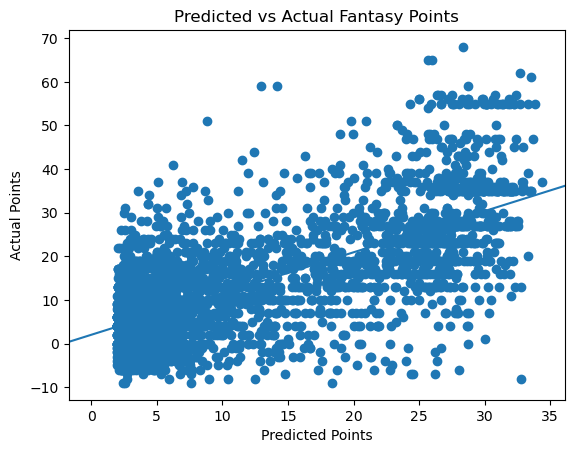

In [28]:
# see how well the monte-carlo method predicts points
f1_sub = f1_pts[f1_pts['dnf'] == 0][['predicted_points','fantasy_points']].dropna()

X = f1_sub['predicted_points']
y = f1_sub['fantasy_points']
X = np.array(X).reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

mc_intercept = model.intercept_
mc_slope = model.coef_[0]

print("R-squared:", r2_score(y, y_pred))

plt.scatter(X, y)
plt.title('Predicted vs Actual Fantasy Points')
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.axline((0, mc_intercept), slope=mc_slope)
plt.show()

In [29]:
# how many predicted winners were accurate
f1_winners = f1_pts[f1_pts['position_num'] == 1]
print(f1_winners['predicted_winner'].value_counts(normalize=True))

1    0.507177
0    0.492823
Name: predicted_winner, dtype: float64


In [30]:
def predicted_constructor_points(f1_df, pts_df):
    constructors = f1_df['constructorId'].unique()
    
    cons_pts = pd.DataFrame(index=constructors, columns=['predicted_points'])
    cons_pts['predicted_points'] = 0
    
    for constructor in constructors:
        # get the drivers for that constructor
        drivers = f1_df[f1_df['constructorId'] == constructor]['driverId']
        
        # Neither driver reaches Q2	-1 point
        # One driver reaches Q2	1 point
        # Both drivers reach Q2	3 points
        # One driver reaches Q3	5 points
        # Both drivers reach Q3	10 points
        
        neither_Q2_pts = -1
        one_Q2_pts = 1
        both_Q2_pts = 3
        one_Q3_pts = 5
        both_Q3_pts = 10
        
        
        for driver in drivers:
            cons_pts.loc[constructor, 'predicted_points'] += pts_df.loc[driver, 'predicted_points']
            
        # add the qualifying points
        if(len(drivers) == 2):
            # get probabilities
            p_Q1 = [pts_df.loc[drivers.values[0], 'Q1_probability'], pts_df.loc[drivers.values[1], 'Q1_probability']]
            p_Q2 = [pts_df.loc[drivers.values[0], 'Q2_probability'], pts_df.loc[drivers.values[1], 'Q2_probability']]
            p_Q3 = [pts_df.loc[drivers.values[0], 'Q3_probability'], pts_df.loc[drivers.values[1], 'Q3_probability']]
            
            # both drivers out in Q1
            prob_both_Q1 = p_Q1[0]*p_Q1[1]
            cons_pts.loc[constructor, 'predicted_points'] += prob_both_Q1*neither_Q2_pts
            
            # one Q2, one Q3
            prob_one_Q2 = p_Q2[0]*p_Q1[1] + p_Q2[1]*p_Q1[0]
            cons_pts.loc[constructor, 'predicted_points'] += prob_one_Q2*one_Q2_pts
            
            # both Q2
            prob_both_Q2 = p_Q2[0]*p_Q2[1]
            cons_pts.loc[constructor, 'predicted_points'] += prob_both_Q2*both_Q2_pts
            
            # one Q3
            prob_one_Q3 = p_Q3[0]*(p_Q2[1] + p_Q1[1]) + p_Q3[1]*(p_Q2[0] + p_Q1[0])
            cons_pts.loc[constructor, 'predicted_points'] += prob_one_Q3*one_Q3_pts
            
            # both Q3
            prob_both_Q3 = p_Q3[0]*p_Q3[1]
            cons_pts.loc[constructor, 'predicted_points'] += prob_both_Q3*both_Q3_pts
            
        ### END IF two drivers
        
    ### END loop through constructors
    
    # apply increase for fastest pit stops
    cons_pts['predicted_points'] *= 1.10
    #cons_pts.sort_values('predicted_points', inplace=True, ascending=False)
    
    return cons_pts
        

In [31]:
def race_total_predicted_points(f1, year, circuit, n_sim=500, display_mc=False, display_pts=False):
    # returns both the driver and constructor predicted points for a given circuit and year
    
    # select just the year and circuit
    mask = (f1['year'] == year) & (f1['circuitId'] == circuit)
    f1_race = f1[mask]
    f1_race.reset_index(drop=True, inplace=True)
    
    # set up XGBoost prediction
    xgb_predictors = ['driverId','constructorId','round','circuitId',
                 'fp1_position','fp2_position','fp3_position','fp1_gap','fp2_gap','fp3_gap','risky_circuit',
                 'position_minus1','fantasy_points_minus1',
                 'position_minus2','fantasy_points_minus2']

    X = f1[xgb_predictors]
    X_dummies = pd.get_dummies(X,columns=['driverId','constructorId','circuitId'])
    X_race = X_dummies[mask]
    X_race.reset_index(drop=True, inplace=True)
    
    # run monte-carlo
    mc_df = race_monte_carlo(X_race, n_sim)
    
    # aggregate monte-carlo
    res_df = monte_carlo_results(f1_race, mc_df, display_mc)
    
    # driver and constructor predicted points
    driver_pts = predicted_driver_points(res_df)
    constructor_pts = predicted_constructor_points(f1_race, driver_pts)
    constructor_pts.sort_values('predicted_points', ascending=False, inplace=True)
    
    if(display_pts):
        display(driver_pts[['predicted_points']])
        display(constructor_pts)
    
    return driver_pts, constructor_pts

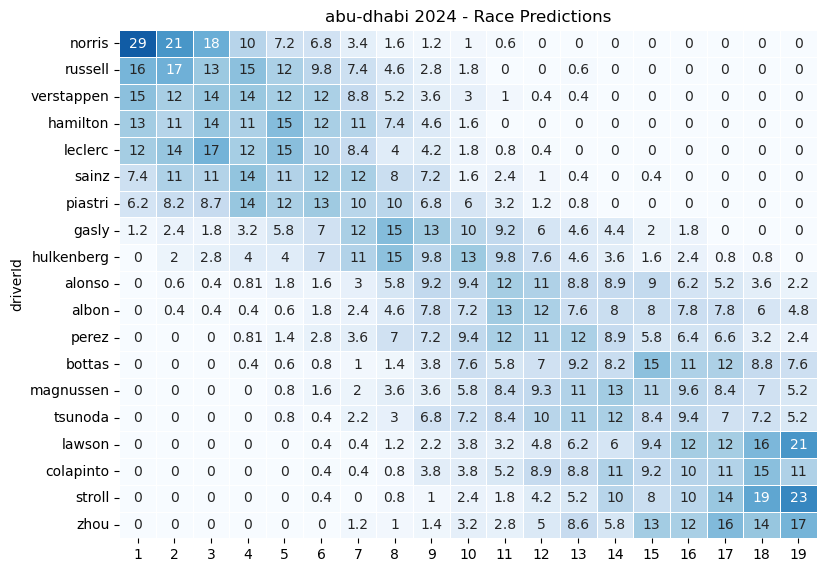

,predicted_points
driverId,
norris,28.521172
russell,25.014871
leclerc,23.887074
verstappen,23.404037
hamilton,22.868542
sainz,20.799345
piastri,19.05278
gasly,10.277019
hulkenberg,9.561533


,predicted_points
mercedes,63.642853
mclaren,63.036491
ferrari,59.883939
red-bull,37.915262
haas,19.374975
alpine,11.304720
aston-martin,10.340462
williams,9.889802
rb,8.470242
kick-sauber,7.730049


In [32]:
year = 2024
circuit = 'abu-dhabi'
d_pts, c_pts = race_total_predicted_points(f1, year, circuit, display_mc=True, display_pts=True, n_sim=500)

In [399]:
f1[f1['year'] == 2024]['circuitId'].unique()

array(['bahrain', 'saudi-arabia', 'australia', 'japan', 'china', 'miami',
       'emilia-romagna', 'monaco', 'canada', 'spain', 'austria',
       'great-britain', 'hungary', 'belgium', 'netherlands', 'italy',
       'azerbaijan', 'singapore', 'united-states', 'mexico', 'sao-paulo',
       'las-vegas', 'qatar', 'abu-dhabi'], dtype=object)

In [33]:
d_pts.to_csv('data/' + str(year) + '_' + circuit + '_d_pts.csv')
c_pts.to_csv('data/' + str(year) + '_' + circuit + '_c_pts.csv')